In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')

In [71]:
# !pip install openpyxl


In [72]:
# Load data from Excel
xlsx_data_file = pd.ExcelFile('data.xlsx')
train_images_df = pd.read_excel(xlsx_data_file, 'azip', header=None)
train_digits_df = pd.read_excel(xlsx_data_file, 'dzip', header=None)
test_images_df = pd.read_excel(xlsx_data_file, 'testzip', header=None)
test_digits_df = pd.read_excel(xlsx_data_file, 'dtest', header=None)

In [73]:
# Convert to numpy arrays
images_train = train_images_df.values 
digits_train = train_digits_df.values.flatten().astype(int)
images_test = test_images_df.values
digits_test = test_digits_df.values.flatten().astype(int)


In [74]:
# Check and fix the shape
print(f"Original training shape: {images_train.shape}")
if images_train.shape[1] == 256:  # If columns are pixels
    images_train = images_train.T  # Now transpose
    images_test = images_test.T

Original training shape: (256, 1707)


In [75]:
# Show sample digits
def show_digit(image_vector, title=""):
   img = image_vector.reshape(16, 16)
   plt.imshow(img, cmap='gray')
   plt.title(title)
   plt.axis('off')

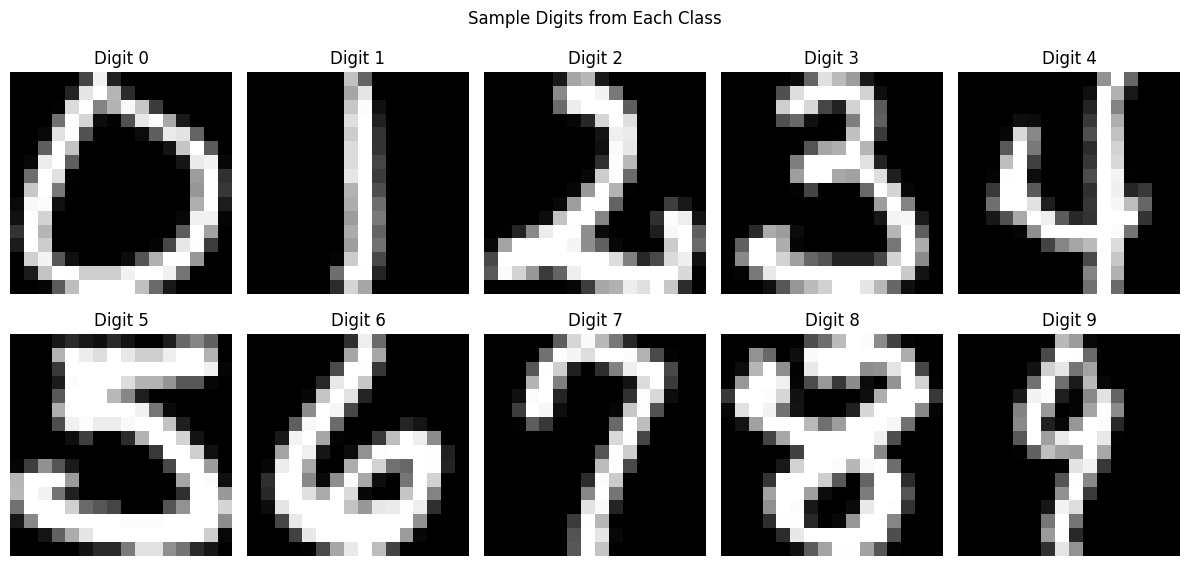

In [76]:
# Display samples from each class
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle("Sample Digits from Each Class")

for digit in range(10):
   row, col = digit // 5, digit % 5
   digit_indices = np.where(digits_train == digit)[0]
   sample_image = images_train[:, digit_indices[0]]
   
   axes[row, col].imshow(sample_image.reshape(16, 16), cmap='gray')
   axes[row, col].set_title(f'Digit {digit}')
   axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [77]:
# Compute SVD for each digit class
svd_bases = {}
singular_values = {}

print("Computing SVD for each digit class...")
for digit in range(10):
    digit_images = images_train[:, digits_train == digit]
    U, S, Vt = np.linalg.svd(digit_images, full_matrices=False)
    svd_bases[digit] = U
    singular_values[digit] = S
    print(f"Digit {digit}: {digit_images.shape[1]} samples")

Computing SVD for each digit class...
Digit 0: 319 samples
Digit 1: 252 samples
Digit 2: 202 samples
Digit 3: 131 samples
Digit 4: 122 samples
Digit 5: 88 samples
Digit 6: 151 samples
Digit 7: 166 samples
Digit 8: 144 samples
Digit 9: 132 samples


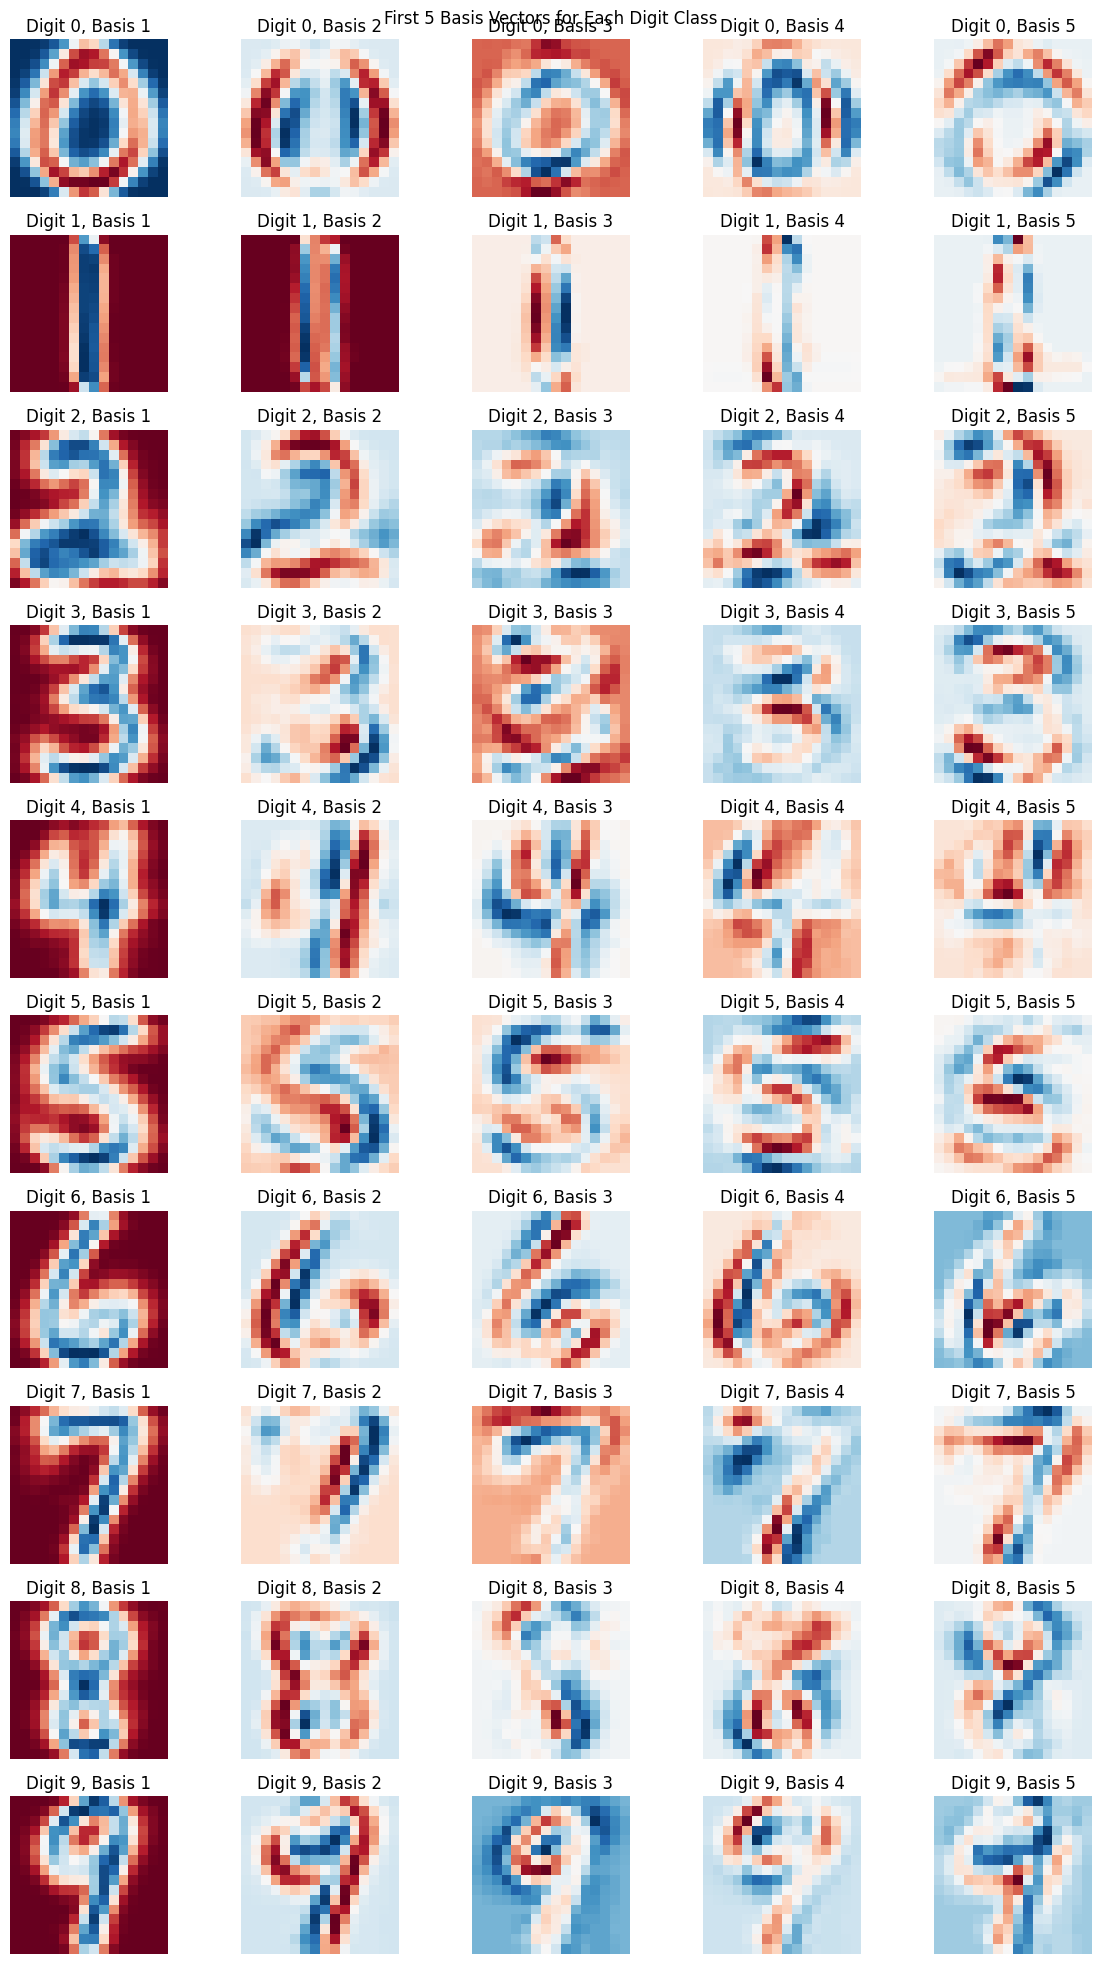

In [78]:
# Show the first 5 basis vectors for each digit
fig, axes = plt.subplots(10, 5, figsize=(12, 20))
fig.suptitle("First 5 Basis Vectors for Each Digit Class")
for digit in range(10):
    for i in range(5):
        basis_vector = svd_bases[digit][:, i].reshape(16, 16)
        axes[digit, i].imshow(basis_vector, cmap='RdBu')
        axes[digit, i].set_title(f'Digit {digit}, Basis {i+1}')
        axes[digit, i].axis('off')
plt.tight_layout()
plt.show()

In [79]:
def classify_with_svd(k=10):
    bases = {}
    for digit in range(10):
        bases[digit] = svd_bases[digit][:, :k]
    
    correct = 0
    for i in range(len(digits_test)):
        test_image = images_test[:, i]
        
        residuals = []
        for digit in range(10):
            basis = bases[digit]
            projection = basis @ (basis.T @ test_image)
            residual = np.linalg.norm(test_image - projection)
            residuals.append(residual)
        
        predicted = np.argmin(residuals)
        if predicted == digits_test[i]:
            correct += 1
    
    return correct / len(digits_test)

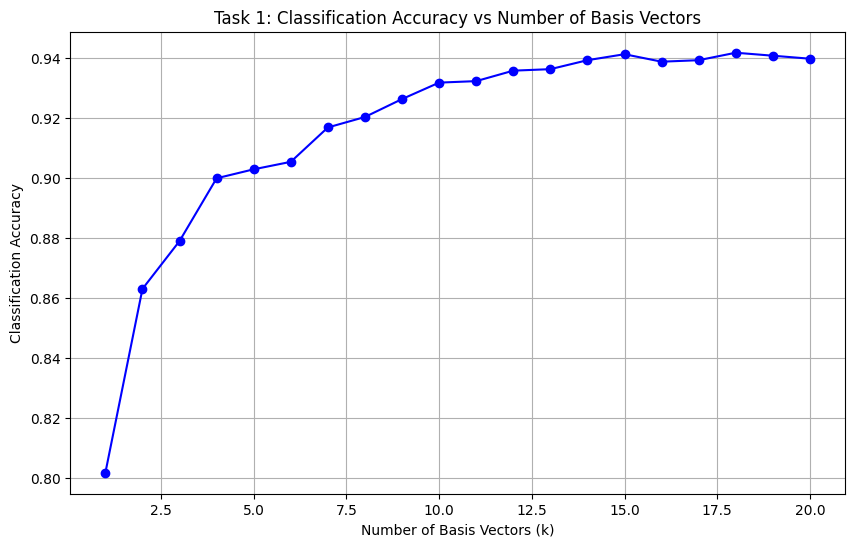

In [80]:
# Task 1: Test different k values
k_values = range(1, 21)
accuracies = []

for k in k_values:
    acc = classify_with_svd(k)
    accuracies.append(acc)

# Plot accuracy curve
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, 'bo-')
plt.xlabel('Number of Basis Vectors (k)')
plt.ylabel('Classification Accuracy')
plt.title('Task 1: Classification Accuracy vs Number of Basis Vectors')
plt.grid(True)
plt.show()

In [81]:
# Task 1 Extension: Results table
print("\nTask 1: Accuracy Results Table")
print("-" * 40)
print("k\tAccuracy")
print("-" * 20)
for i, k in enumerate(k_values):
    print(f"{k}\t{accuracies[i]:.4f}")


Task 1: Accuracy Results Table
----------------------------------------
k	Accuracy
--------------------
1	0.8017
2	0.8630
3	0.8789
4	0.8999
5	0.9028
6	0.9053
7	0.9168
8	0.9203
9	0.9263
10	0.9317
11	0.9322
12	0.9357
13	0.9362
14	0.9392
15	0.9412
16	0.9387
17	0.9392
18	0.9417
19	0.9407
20	0.9397


In [82]:
# Task 2: Find difficult cases
def find_difficult_cases(k=10):
    bases = {digit: svd_bases[digit][:, :k] for digit in range(10)}
    
    misclassified = []
    for i in range(len(digits_test)):
        test_image = images_test[:, i]
        true_label = digits_test[i]
        
        residuals = []
        for digit in range(10):
            basis = bases[digit]
            projection = basis @ (basis.T @ test_image)
            residual = np.linalg.norm(test_image - projection)
            residuals.append(residual)
        
        predicted = np.argmin(residuals)
        if predicted != true_label:
            misclassified.append({
                'index': i,
                'true': true_label,
                'predicted': predicted,
                'image': test_image
            })
    
    return misclassified

difficult_cases = find_difficult_cases()
print(f"Total misclassified: {len(difficult_cases)}")


Total misclassified: 137


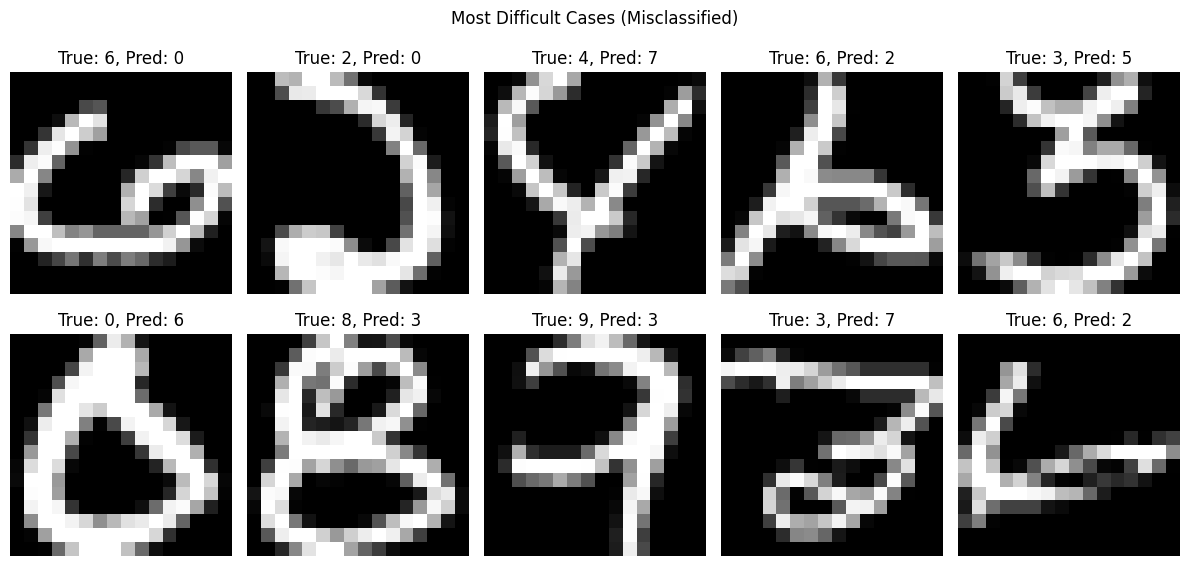

In [83]:
# Show difficult cases
if len(difficult_cases) >= 10:
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    fig.suptitle("Most Difficult Cases (Misclassified)")
    for i in range(10):
        row, col = i // 5, i % 5
        case = difficult_cases[i]
        axes[row, col].imshow(case['image'].reshape(16, 16), cmap='gray')
        axes[row, col].set_title(f"True: {case['true']}, Pred: {case['predicted']}")
        axes[row, col].axis('off')
    plt.tight_layout()
    plt.show()

In [84]:
def analyze_per_class_accuracy(k=10):
    bases = {digit: svd_bases[digit][:, :k] for digit in range(10)}
    
    # Track predictions for each digit
    predictions = []
    true_labels = []
    
    for i in range(len(digits_test)):
        test_image = images_test[:, i]
        true_label = digits_test[i]
        
        residuals = []
        for digit in range(10):
            basis = bases[digit]
            projection = basis @ (basis.T @ test_image)
            residual = np.linalg.norm(test_image - projection)
            residuals.append(residual)
        
        predicted = np.argmin(residuals)
        predictions.append(predicted)
        true_labels.append(true_label)
    
    # Calculate per-class accuracy
    per_class_acc = {}
    for digit in range(10):
        digit_indices = np.where(np.array(true_labels) == digit)[0]
        digit_predictions = np.array(predictions)[digit_indices]
        accuracy = np.sum(digit_predictions == digit) / len(digit_indices)
        per_class_acc[digit] = accuracy
    
    return per_class_acc, predictions, true_labels

# Run per-class analysis
per_class_acc, predictions, true_labels = analyze_per_class_accuracy(k=10)

# Display results
print("Per-class Classification Accuracy:")
print("-" * 35)
for digit in range(10):
    print(f"Digit {digit}: {per_class_acc[digit]:.3f}")

Per-class Classification Accuracy:
-----------------------------------
Digit 0: 0.983
Digit 1: 0.989
Digit 2: 0.904
Digit 3: 0.880
Digit 4: 0.915
Digit 5: 0.869
Digit 6: 0.941
Digit 7: 0.939
Digit 8: 0.873
Digit 9: 0.938


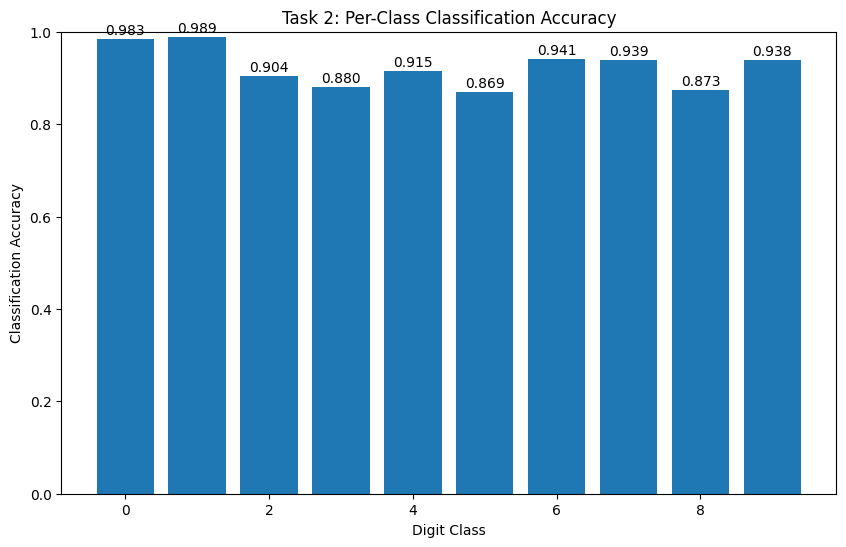

In [85]:
# Plot per-class accuracy
plt.figure(figsize=(10, 6))
digits = list(range(10))
accuracies_per_class = [per_class_acc[d] for d in digits]
plt.bar(digits, accuracies_per_class)
plt.xlabel('Digit Class')
plt.ylabel('Classification Accuracy')
plt.title('Task 2: Per-Class Classification Accuracy')
plt.ylim(0, 1)
for i, acc in enumerate(accuracies_per_class):
    plt.text(i, acc + 0.01, f'{acc:.3f}', ha='center')
plt.show()

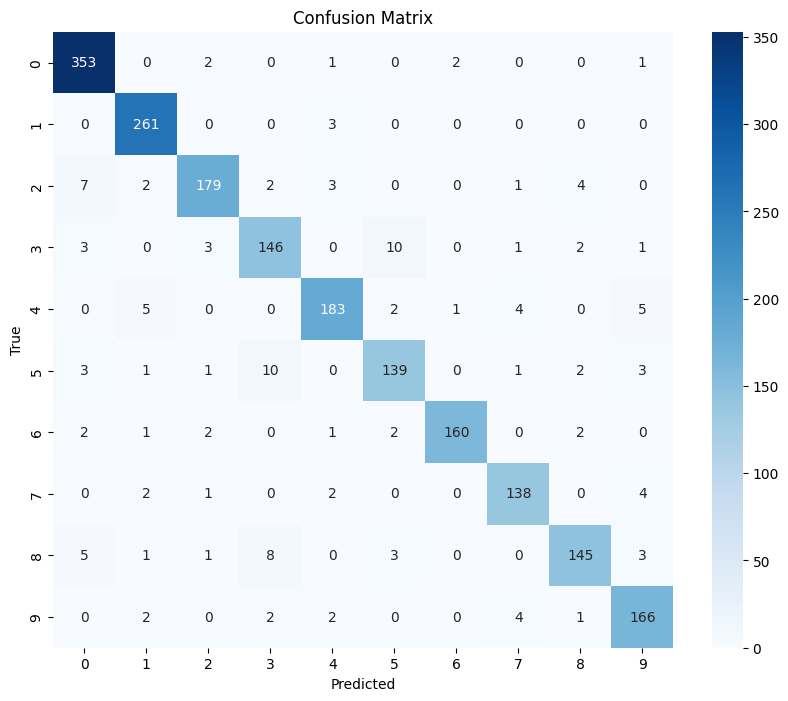

In [86]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

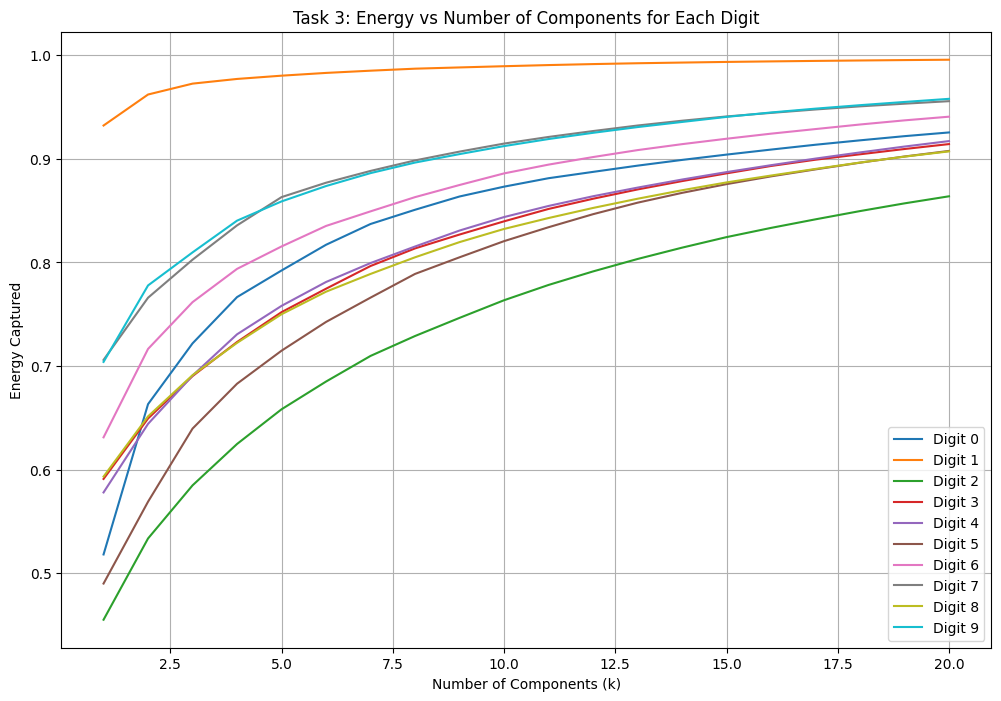

In [87]:
# Task 3: Check if different digits need different k values
for digit in range(10):
    S = singular_values[digit]
    total_energy = np.sum(S**2)
    
    for k in [5, 10, 15]:
        energy_k = np.sum(S[:k]**2)
        energy_ratio = energy_k / total_energy

# Show energy distribution
plt.figure(figsize=(12, 8))
for digit in range(10):
    S = singular_values[digit]
    energy_ratios = []
    for k in range(1, 21):
        energy_k = np.sum(S[:k]**2)
        total_energy = np.sum(S**2)
        energy_ratios.append(energy_k / total_energy)
    
    plt.plot(range(1, 21), energy_ratios, label=f'Digit {digit}')

plt.xlabel('Number of Components (k)')
plt.ylabel('Energy Captured')
plt.title('Task 3: Energy vs Number of Components for Each Digit')
plt.legend()
plt.grid(True)
plt.show()

In [88]:
# Task 3 Extension: Test adaptive k values
def classify_with_adaptive_k(k_values):
    """Test classification with different k values for each digit class"""
    bases = {}
    for digit in range(10):
        k = k_values[digit] if isinstance(k_values, dict) else k_values
        bases[digit] = svd_bases[digit][:, :k]
    
    correct = 0
    for i in range(len(digits_test)):
        test_image = images_test[:, i]
        
        residuals = []
        for digit in range(10):
            basis = bases[digit]
            projection = basis @ (basis.T @ test_image)
            residual = np.linalg.norm(test_image - projection)
            residuals.append(residual)
        
        predicted = np.argmin(residuals)
        if predicted == digits_test[i]:
            correct += 1
    
    return correct / len(digits_test)

# Test different adaptive strategies
print("\nTask 3: Testing Adaptive k Values")
print("-" * 40)

# Strategy 1: Use k based on 90% energy capture
adaptive_k_90 = {}
for digit in range(10):
    S = singular_values[digit]
    total_energy = np.sum(S**2)
    for k in range(1, len(S)):
        energy_k = np.sum(S[:k]**2)
        if energy_k / total_energy >= 0.9:
            adaptive_k_90[digit] = k
            break

print("90% Energy Strategy:")
for digit in range(10):
    print(f"  Digit {digit}: k={adaptive_k_90[digit]}")

acc_adaptive_90 = classify_with_adaptive_k(adaptive_k_90)
acc_uniform_10 = classify_with_adaptive_k(10)

print(f"\nUniform k=10: {acc_uniform_10:.4f}")
print(f"Adaptive 90% energy: {acc_adaptive_90:.4f}")
print(f"Improvement: {acc_adaptive_90 - acc_uniform_10:.4f}")

# Strategy 2: Use fewer k for digits with faster decay
adaptive_k_custom = {0: 8, 1: 5, 2: 12, 3: 10, 4: 9, 5: 11, 6: 8, 7: 6, 8: 13, 9: 10}
acc_custom = classify_with_adaptive_k(adaptive_k_custom)
print(f"Custom adaptive: {acc_custom:.4f}")


Task 3: Testing Adaptive k Values
----------------------------------------
90% Energy Strategy:
  Digit 0: k=15
  Digit 1: k=1
  Digit 2: k=28
  Digit 3: k=18
  Digit 4: k=17
  Digit 5: k=19
  Digit 6: k=12
  Digit 7: k=9
  Digit 8: k=19
  Digit 9: k=9

Uniform k=10: 0.9317
Adaptive 90% energy: 0.9088
Improvement: -0.0229
Custom adaptive: 0.9258
